<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294482 entries, 0 to 294481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294482 non-null  int64 
 1   timestamp     294482 non-null  object
 2   group         294482 non-null  object
 3   landing_page  294482 non-null  object
 4   converted     294482 non-null  int64 
 5   country       294482 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.5+ MB


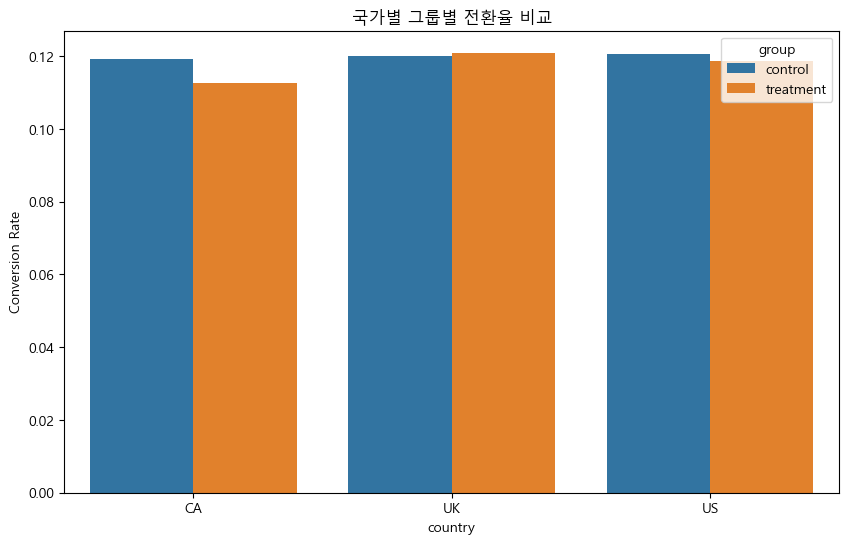

CA: Z=1.28, p=0.202 → 차이 없음
UK: Z=-0.33, p=0.745 → 차이 없음
US: Z=1.34, p=0.182 → 차이 없음


In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows Korean font
mpl.rcParams['axes.unicode_minus'] = False     # To show minus sign correctly

# 데이터 로드
df_ab = pd.read_csv('../data/ab_data.csv')
df_ct = pd.read_csv('../data/countries.csv')

# 데이터 합치기
df = pd.merge(df_ab, df_ct, on='user_id', how='left')
df.head(), df.info()
# 1. 국가별 전환율 통계 요약
country_summary = df.groupby(['country', 'group'])['converted'] \
    .agg(['sum', 'count']).reset_index() \
    .rename(columns={'sum': 'conversions', 'count': 'total'})
country_summary['conversion_rate'] = country_summary['conversions'] / country_summary['total']

# 2. 국가별 Z-test 수행
results = []
for country in country_summary['country'].unique():
    subset = country_summary[country_summary['country'] == country]
    if len(subset) == 2:
        count = subset['conversions'].values
        nobs = subset['total'].values
        z_stat, p_val = proportions_ztest(count, nobs)
        results.append({'country': country, 'z_stat': z_stat, 'p_value': p_val})
    else:
        results.append({'country': country, 'z_stat': np.nan, 'p_value': np.nan})

country_stats = pd.DataFrame(results)

# 3. 병합 및 시각화
report = pd.merge(country_summary, country_stats, on='country')

# 4. 바 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(data=country_summary, x='country', y='conversion_rate', hue='group')
plt.title('국가별 그룹별 전환율 비교')
plt.ylabel('Conversion Rate')
plt.savefig('../outputs/figures/04_country_subgroup_conv.png')
plt.show()

# 5. 결과 해석
for _, row in country_stats.iterrows():
    if pd.notna(row['p_value']):
        sig = '유의미한 차이 있음' if row['p_value'] < 0.05 else '차이 없음'
        print(f"{row['country']}: Z={row['z_stat']:.2f}, p={row['p_value']:.3f} → {sig}")
